In [24]:

# coding: utf-8
import os
import re
import datetime

import _main as pp

import turbodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans

sns.set(style="whitegrid")

def to_pivot(df):
    pvt = pd.DataFrame()
    cols = ['Preis_Konkurrenz',
            'Txt_Kurz_Konkurrenz',
            'Txt_Lang_Konkurrenz',
            'Joined_on',
            'Preisdifferenz',
            'Closest', 'Distance']
    for i in cols:
        pvt_ = df.pivot(index='UID', columns='Konkurrenz', values=i)
        pvt_.columns = [i + '_' + j for j in pvt_.columns]
        pvt = pd.concat([pvt, pvt_], axis=1)
    pvt = df.merge(
        pvt, left_on='UID',
        right_index=True)
    pvt.drop(cols, axis=1, inplace=True)
    pvt.drop('Konkurrenz', axis=1, inplace=True)
    pvt.drop_duplicates(inplace=True)
    return pvt.reset_index(drop=True)


def load_price_group():
    f = os.path.join(pp.Path, "Dotdat", "Output")
    folders = os.listdir(f)
    folders.sort(reverse=True)
    folder = folders[0]
    df = pd.read_csv(os.path.join(f, folder, "KOMWGR.csv"),
        sep="\t", dtype=str)
    df['Warengruppe_Bezeichnung'] = df["Text deutsch"]
    df = df[df.groupby(
        'Warengruppe')['Warengruppe_Bezeichnung'].rank(method='dense')==1]
    return df.drop_duplicates()


def join_price_group(df):
    priceg = load_price_group()
    df = df.merge(priceg[["Warengruppe", "Warengruppe_Bezeichnung"]],
        how="left", on="Warengruppe")
    return df.drop_duplicates()


def get_companies(df):
    companies = [i[17:] for i in df.columns if i.startswith(
        "Preis_") and not i.endswith("Log")]
    return companies


def prep_df(df):
    companies = get_companies(df)

    for i in df:
        try:
            if df[i].dtype == 'O':
                df[i] = df[i].str.replace("\r", "")
                df[i] = df[i].str.replace("\n", " ")
                df[i] = df[i].str.replace('"', "")
                df[i] = df[i].str.strip()
        except AttributeError:
            continue

    for j, i in enumerate(companies):
        print("{} Company in data: {}".format(j+1, i))

    df['Discount_perc'] = (df['GrossSales_LTM'] -
                           df['Sales_LTM']) / df['GrossSales_LTM']
    df['Margin_perc'] = df['Margin_LTM'] / df['Sales_LTM']
    df['ProCasa'] = (df['Art_Txt_Lang']
                      .str.lower()
                      .str.replace(" ", "")
                      .str.contains("procasa"))

    for i in ['GrossSales_LTM', 'Sales_LTM',
              'Margin_LTM', 'Quantity_LTM',
              'ObjectRate', 'CountOfOrders', 'Preis',
              'CountOfCustomers', 'Discount_perc', 'Margin_perc']:
        df[i] = df[i].astype(np.float)
        df[i + '_Log'] = df[i].apply(lambda x: np.log(x + 1))

    df['GrossSales_Calculated'] = df['Preis'] * df['Quantity_LTM']

    for i in companies:
        df['Preis_Konkurrenz_' +
            i] = df['Preis_Konkurrenz_' + i].astype(np.float)
        df['Preis_Konkurrenz_' + i + '_Log'] = df['Preis_Konkurrenz_' +
            i].apply(lambda x: np.log(x + 1))
        df['Outlier_' + i] = np.nan
        df['GrossSales_Calculated_' + i] = df['Preis_Konkurrenz_' + i] * \
            df['Quantity_LTM']
    return df.drop_duplicates()


def cluster(df, X=None, tag='', clusters=5, scaler_obj=StandardScaler):
    if tag in df.columns:
        df[tag] = np.nan
    if not X:
        X = df
    else:
        X = df[X]
    norm = scaler_obj()
    normalized = norm.fit_transform(X)
    kmeans = KMeans(
        n_clusters=clusters, random_state=23).fit(normalized)
    df[tag] = kmeans.labels_
    return df.drop_duplicates()


def outlier_detection(df, threshold=1.5):
    companies = get_companies(df)
    for i in companies:
        df_temp = df[['Preis', 'Preis_Konkurrenz_' + i]
            ].replace('', np.nan).dropna(how='any').copy()
        df_temp['Preis'] = df_temp['Preis'].astype(np.float)
        df_temp['Preis_Konkurrenz_' +
            i] = df_temp['Preis_Konkurrenz_' + i].astype(np.float)
        df_temp['Diff'] = df_temp['Preis'] - df_temp['Preis_Konkurrenz_' + i]
        df['Outlier_' + i] = False
        df_temp['Outlier_' + i] = (np.abs(
                df_temp['Diff']) / df_temp['Preis']) > threshold * (
                np.std(df_temp['Diff']) / df_temp['Preis'])
        df.update(df_temp)
    return df.drop_duplicates()

def map_cluster(df):
    cluster_cols = [i for i in df.columns if i.startswith("Cluster")]
    for i in cluster_cols:
        cols = re.sub("_Log|Cluster_", "", i).split("_&_")
        #grouped = df[df[i]!='Nicht zugeordnet'].groupby(i)
        grouped = df.groupby(i)[cols].mean()
        
        mp = {1: "(1) Low", 2: "(2) Low", 3: "(2) High", 4: "(1) High"}
        
        grouped[cols[0]+'_rank'] = grouped[cols[0]].rank().map(mp)
        grouped[cols[1]+'_rank'] = grouped[cols[1]].rank().map(mp)
        
        grouped['Cluster'] = grouped[[cols[0]+'_rank', cols[1]+'_rank']].apply(
            lambda x: "{} {}, {} {}".format(x[0], cols[0].split("_")[0],
                                            x[1], cols[1].split("_")[0]), axis=1)
        
        df[i] = df[i].map(grouped['Cluster']).fillna("Nicht zugeordnet")
    return df

def get_cluster(df, plot=True):
    for i in [['Margin_perc', 'Sales_LTM_Log', StandardScaler, 4],
              ['Quantity_LTM_Log', 'Sales_LTM_Log', StandardScaler, 4],
              ['ObjectRate', 'Sales_LTM_Log', StandardScaler, 4]]:

        tag = 'Cluster_' + '_&_'.join(i[:2])

        dfs = df.query(
            "Margin_perc > 0.0001 and Sales_LTM > 100 and Margin_perc < 0.9").copy()
        dfs = (dfs.pipe(cluster, X=[i[0], i[1]],
                       tag=tag, clusters=i[3], scaler_obj=i[2])
                   .pipe(map_cluster))        
        #print(grouped)

        #dfs[tag] = dfs[tag].map(i[4])
        #dfs[tag] = dfs[tag] + 1

        if plot:
            splt = sns.lmplot(i[0], i[1],
                       data=dfs, hue=tag,
                       fit_reg=False, size=7,
                       aspect=1.6,
                       palette=sns.color_palette('colorblind'))
            splt._legend.set_title("Cluster")

            plt.savefig(os.path.join(pp.Path, "Plots", "PDF", tag + ".pdf"))
            plt.savefig(os.path.join(pp.Path, "Plots", "PNG", tag + ".png"))
        
        df[tag] = "Nicht zugeordnet"
        df.update(dfs[tag])
    return df.drop_duplicates()


def plot_outlier(df):
    for i in get_companies(df):
        dfplot = df[(df['Joined_on_' + i] != 'Text_Similarity') & (pd.notnull(
            df['Preis_Konkurrenz_' + i]))]
        f, ax = plt.subplots(figsize=(20, 20))
        p1 = sns.regplot('Preis_Konkurrenz_' + i, 'Preis',
                         data=dfplot, fit_reg=False)
        for line in range(0, dfplot.shape[0]):
            if dfplot.Outlier_Sanitas.iloc[line]:
                p1.text(dfplot.Preis_Konkurrenz_Sanitas.iloc[line] + 0.5,
                        dfplot.Preis.iloc[line], dfplot.Art_Txt_Kurz.iloc[line],
                        horizontalalignment='left', size='medium', color='black')
        plt.savefig(os.path.join(pp.Path, "Plots",
                    "PDF", "Outlier_{}.pdf".format(i)))
        plt.savefig(os.path.join(pp.Path, "Plots",
                    "PGN", "Outlier_{}.pgn".format(i)))

In [2]:
query = pp.load_sql_text(os.path.join(pp.Path, "SQL", "Sales.sql")).strip()

con = pp.create_connection_string_turbo("CRHBUSADWH02", 'AnalystCM')
meta = pp.sql_to_pandas(con, query)

In [3]:
files = [i for i in os.listdir(os.path.join(
    pp.Path, "Matched")) if i.endswith(".csv")]
files.sort(reverse=True)
file_ = files[0]

In [4]:
df = pd.read_csv(os.path.join(
            pp.Path, "Matched", file_), sep="\t", dtype=str)
df_back = df.copy()

In [25]:
df = df_back

Loading and preparing data...
1 Company in data: Sabag
2 Company in data: Saneo
3 Company in data: Sanitas
4 Company in data: TeamHug
5 Company in data: TeamKappeler
6 Company in data: TeamMaga
7 Company in data: TeamSaniDusch


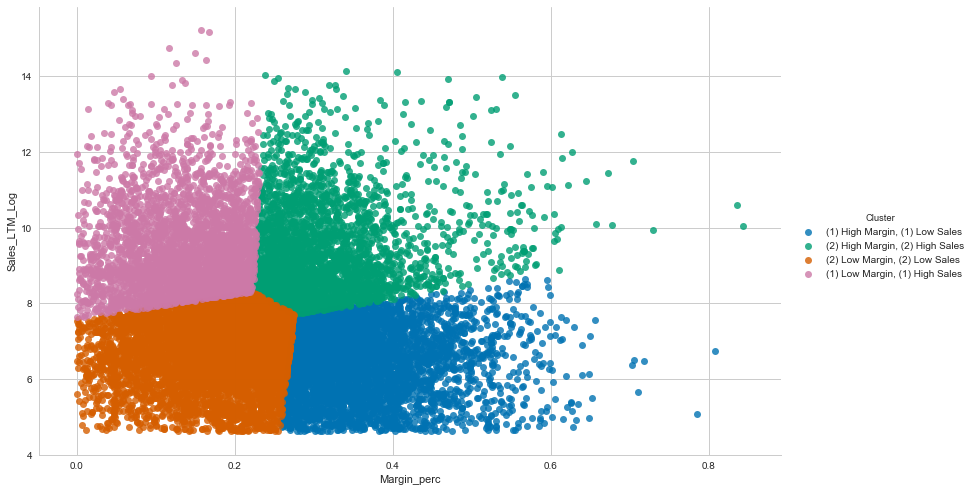

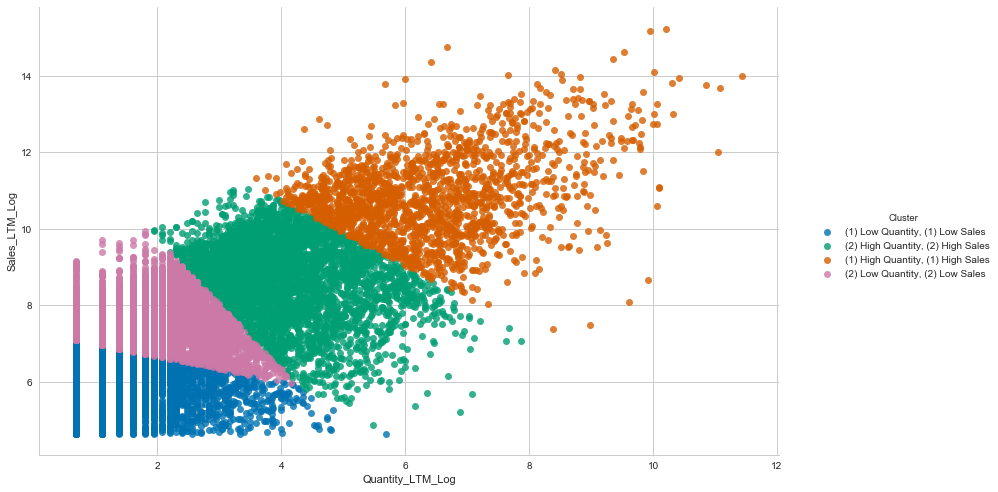

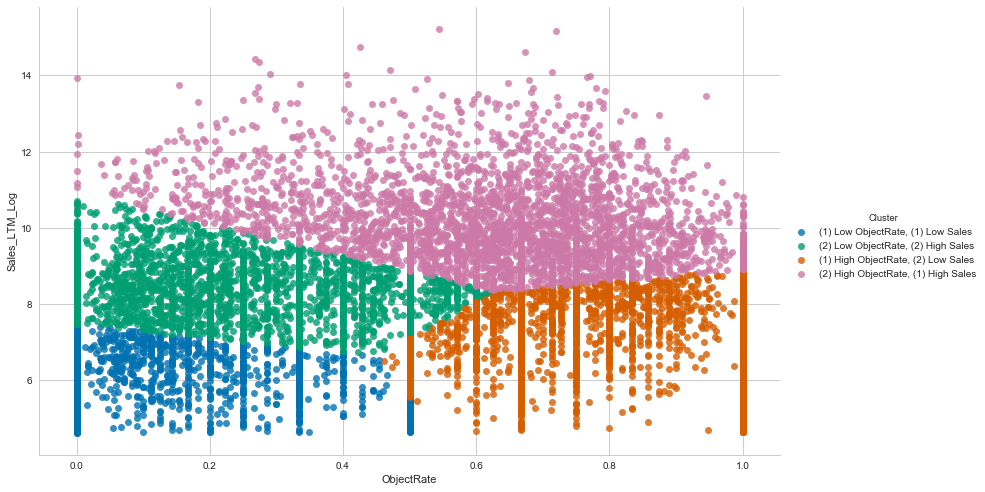

In [26]:
print("Loading and preparing data...")
df = (df.pipe(to_pivot)
        .merge(meta, how='left', left_on='UID', right_on='UniqueId')
        .pipe(prep_df)
        .drop_duplicates(inplace=False)
        .pipe(outlier_detection, threshold=2.5)
        .pipe(get_cluster, plot=True)
        .pipe(join_price_group)
        .drop_duplicates(inplace=False))

In [11]:
df

,ArtikelId,FarbId,AusführungsId,UID,Art_Txt_Kurz,Art_Txt_Lang,Ausführung,Farbe,EAN,Konkurrenznummer,...,Preis_Konkurrenz_TeamMaga_Log,Outlier_TeamMaga,GrossSales_Calculated_TeamMaga,Preis_Konkurrenz_TeamSaniDusch_Log,Outlier_TeamSaniDusch,GrossSales_Calculated_TeamSaniDusch,Cluster_Margin_perc_&_Sales_LTM_Log,Cluster_Quantity_LTM_Log_&_Sales_LTM_Log,Cluster_ObjectRate_&_Sales_LTM_Log,Warengruppe_Bezeichnung
0,014671,000,NaN,014671000,Tauchrohr TECEdrainline zu Ablauf flach 146 771,Tauchrohr TECEdrainline zu Ablauf flach 146 771,NaN,NaN,NaN,NaN,...,3.198673,False,987.0,3.157000,False,945.0,Cluster_Margin_perc_&_Sales_LTM_Log\n0 Low...,Cluster_Quantity_LTM_Log_&_Sales_LTM_Log\n0 ...,Cluster_ObjectRate_&_Sales_LTM_Log\n0 Low\...,Ersatzteile_Slow
2,014672,000,NaN,014672000,Tauchrohr TECEdrainline zu Ablauf Norm 146 772,Tauchrohr TECEdrainline zu Ablauf Norm 146 772,NaN,NaN,NaN,NaN,...,3.198673,False,1527.5,3.157000,False,1462.5,Cluster_Margin_perc_&_Sales_LTM_Log\n0 Low...,Cluster_Quantity_LTM_Log_&_Sales_LTM_Log\n0 ...,Cluster_ObjectRate_&_Sales_LTM_Log\n0 Low\...,Ersatzteile_Slow
4,014673,000,NaN,014673000,Tauchrohr TECEdrainline zu Ablauf max und senk...,Tauchrohr TECEdrainline zu Ablauf max und senk...,NaN,NaN,NaN,NaN,...,3.198673,False,235.0,3.157000,False,225.0,Nicht zugeordnet,Nicht zugeordnet,Nicht zugeordnet,Ersatzteile_Slow
6,014674,000,NaN,014674000,Tauchrohr TECEdrainline zu Ablauf superflach 1...,Tauchrohr TECEdrainline zu Ablauf superflach 1...,NaN,NaN,NaN,NaN,...,3.198673,False,235.0,3.157000,False,225.0,Nicht zugeordnet,Nicht zugeordnet,Nicht zugeordnet,Ersatzteile_Slow
8,014675,000,NaN,014675000,Membran-Geruchsverschluss für Ablauf TECEdrain...,Membran-Geruchsverschluss für Ablauf TECEdrain...,NaN,NaN,NaN,NaN,...,3.555348,False,68.0,3.511545,False,65.0,Nicht zugeordnet,Nicht zugeordnet,Nicht zugeordnet,Ersatzteile_Slow
10,014676,000,NaN,014676000,Membran-Geruchsverschluss für Ablauf TECEdrain...,Membran-Geruchsverschluss für Ablauf TECEdrain...,NaN,NaN,NaN,NaN,...,3.624341,False,365.0,3.583519,False,350.0,Cluster_Margin_perc_&_Sales_LTM_Log\n0 Low...,Cluster_Quantity_LTM_Log_&_Sales_LTM_Log\n0 ...,Cluster_ObjectRate_&_Sales_LTM_Log\n0 Low\...,Ersatzteile_Slow
12,014677,000,NaN,014677000,Membran-Geruchsverschluss für Ablauf TECEdrain...,Membran-Geruchsverschluss für Ablauf TECEdrain...,NaN,NaN,NaN,NaN,...,3.676301,False,269.5,3.637586,False,259.0,Cluster_Margin_perc_&_Sales_LTM_Log\n0 Low...,Cluster_Quantity_LTM_Log_&_Sales_LTM_Log\n0 ...,Cluster_ObjectRate_&_Sales_LTM_Log\n0 Low\...,Ersatzteile_Slow
14,014678,000,NaN,014678000,Membran-Geruchsverschluss für Ablauf TECEdrain...,Membran-Geruchsverschluss für Ablauf TECEdrain...,NaN,NaN,NaN,NaN,...,3.688879,False,NaN,3.650658,False,NaN,Nicht zugeordnet,Nicht zugeordnet,Nicht zugeordnet,Ersatzteile
15,014690,520,NaN,014690520,Rinnenkörper JOULIA INLINE für 3-Rohr-Wärmetau...,Rinnenkörper JOULIA INLINE für 3-Rohr-Wärmetau...,NaN,Edelstahl,NaN,NaN,...,6.661855,False,NaN,6.566672,False,NaN,Nicht zugeordnet,Nicht zugeordnet,Nicht zugeordnet,Ersatzteile
16,014691,520,NaN,014691520,Rinnenkörper JOULIA INLINE für 3-Rohr-Wärmetau...,Rinnenkörper JOULIA INLINE für 3-Rohr-Wärmetau...,NaN,Edelstahl,NaN,NaN,...,6.661855,False,NaN,6.566672,False,NaN,Nicht zugeordnet,Nicht zugeordnet,Nicht zugeordnet,Ersatzteile


In [91]:
dt = datetime.datetime.now()

settings = pp.load_json(os.path.join(pp.Path, "settings.json"))["Sanitary"]
cols = settings['Output Columns']

df = df[cols].drop_duplicates()

In [93]:
df

,ArtikelId,UID,Art_Txt_Lang,Preis,Category_Level_1,Category_Level_2,Category_Level_3,Category_Level_4,Preis_Konkurrenz_Sabag,Preis_Konkurrenz_Saneo,...,Outlier_Sanitas,Outlier_TeamHug,Outlier_TeamKappeler,Outlier_TeamMaga,Outlier_TeamSaniDusch,Cluster_Margin_perc_&_Sales_LTM_Log,Cluster_Quantity_LTM_Log_&_Sales_LTM_Log,Cluster_ObjectRate_&_Sales_LTM_Log,Warengruppe,Warengruppe_Bezeichnung
0,014671,014671000,Tauchrohr TECEdrainline zu Ablauf flach 146 771,24.5,Ersatzteile,zu Duschenelemente,TECEdrainline,TECEdrainline,24.5,23.5,...,False,False,False,False,False,"High Margin, Low Sales","Low Quantity, Low Sales","Low ObjectRate, Low Sales",201,Ersatzteile_Slow
2,014672,014672000,Tauchrohr TECEdrainline zu Ablauf Norm 146 772,24.5,Ersatzteile,zu Duschenelemente,TECEdrainline,TECEdrainline,24.5,23.5,...,False,False,False,False,False,"High Margin, Low Sales","Low Quantity, Low Sales","Low ObjectRate, Low Sales",201,Ersatzteile_Slow
4,014673,014673000,Tauchrohr TECEdrainline zu Ablauf max und senk...,24.5,Ersatzteile,zu Duschenelemente,TECEdrainline,TECEdrainline,24.5,23.5,...,False,False,False,False,False,Nicht zugeordnet,Nicht zugeordnet,Nicht zugeordnet,201,Ersatzteile_Slow
6,014674,014674000,Tauchrohr TECEdrainline zu Ablauf superflach 1...,24.5,Ersatzteile,zu Duschenelemente,TECEdrainline,TECEdrainline,24.5,23.5,...,False,False,False,False,False,Nicht zugeordnet,Nicht zugeordnet,Nicht zugeordnet,201,Ersatzteile_Slow
8,014675,014675000,Membran-Geruchsverschluss für Ablauf TECEdrain...,35.5,Ersatzteile,zu Duschenelemente,TECEdrainline,TECEdrainline,35.5,34.0,...,False,False,False,False,False,Nicht zugeordnet,Nicht zugeordnet,Nicht zugeordnet,201,Ersatzteile_Slow
10,014676,014676000,Membran-Geruchsverschluss für Ablauf TECEdrain...,38.0,Ersatzteile,zu Duschenelemente,TECEdrainline,TECEdrainline,38.0,36.5,...,False,False,False,False,False,"High Margin, Low Sales","Low Quantity, Low Sales","Low ObjectRate, Low Sales",201,Ersatzteile_Slow
12,014677,014677000,Membran-Geruchsverschluss für Ablauf TECEdrain...,40.0,Ersatzteile,zu Duschenelemente,TECEdrainline,TECEdrainline,40.0,38.5,...,False,False,False,False,False,"High Margin, Low Sales","Low Quantity, Low Sales","Low ObjectRate, Low Sales",201,Ersatzteile_Slow
14,014678,014678000,Membran-Geruchsverschluss für Ablauf TECEdrain...,37.0,Ersatzteile,zu Duschenelemente,TECEdrainline,TECEdrainline,40.5,39.0,...,False,False,False,False,False,Nicht zugeordnet,Nicht zugeordnet,Nicht zugeordnet,010,Ersatzteile
15,014690,014690520,Rinnenkörper JOULIA INLINE für 3-Rohr-Wärmetau...,781.0,Ersatzteile,zu Duschenelemente,Inline,01,746.0,781.0,...,False,False,False,False,False,Nicht zugeordnet,Nicht zugeordnet,Nicht zugeordnet,010,Ersatzteile
16,014691,014691520,Rinnenkörper JOULIA INLINE für 3-Rohr-Wärmetau...,781.0,Ersatzteile,zu Duschenelemente,Inline,01,746.0,781.0,...,False,False,False,False,False,Nicht zugeordnet,Nicht zugeordnet,Nicht zugeordnet,010,Ersatzteile


In [58]:

measure_cols = [re.sub("_Log|Cluster_", "", i).split("_&_") for i in cluster_cols]

In [59]:
measure_cols

[['Margin_perc', 'Sales_LTM'],
 ['Quantity_LTM', 'Sales_LTM'],
 ['ObjectRate', 'Sales_LTM']]

In [69]:
df = df.pipe(map_cluster)

In [70]:
df.head()

,ArtikelId,FarbId,AusführungsId,UID,Art_Txt_Kurz,Art_Txt_Lang,Ausführung,Farbe,EAN,Konkurrenznummer,...,Preis_Konkurrenz_TeamMaga_Log,Outlier_TeamMaga,GrossSales_Calculated_TeamMaga,Preis_Konkurrenz_TeamSaniDusch_Log,Outlier_TeamSaniDusch,GrossSales_Calculated_TeamSaniDusch,Cluster_Margin_perc_&_Sales_LTM_Log,Cluster_Quantity_LTM_Log_&_Sales_LTM_Log,Cluster_ObjectRate_&_Sales_LTM_Log,Warengruppe_Bezeichnung
0,014671,000,NaN,014671000,Tauchrohr TECEdrainline zu Ablauf flach 146 771,Tauchrohr TECEdrainline zu Ablauf flach 146 771,NaN,NaN,NaN,NaN,...,3.198673,False,987.0,3.157000,False,945.0,"Low Margin, Low Sales","Low Quantity, Low Sales","Low ObjectRate, Low Sales",Ersatzteile_Slow
2,014672,000,NaN,014672000,Tauchrohr TECEdrainline zu Ablauf Norm 146 772,Tauchrohr TECEdrainline zu Ablauf Norm 146 772,NaN,NaN,NaN,NaN,...,3.198673,False,1527.5,3.157000,False,1462.5,"Low Margin, Low Sales","Low Quantity, Low Sales","Low ObjectRate, Low Sales",Ersatzteile_Slow
4,014673,000,NaN,014673000,Tauchrohr TECEdrainline zu Ablauf max und senk...,Tauchrohr TECEdrainline zu Ablauf max und senk...,NaN,NaN,NaN,NaN,...,3.198673,False,235.0,3.157000,False,225.0,Nicht zugeordnet,Nicht zugeordnet,Nicht zugeordnet,Ersatzteile_Slow
6,014674,000,NaN,014674000,Tauchrohr TECEdrainline zu Ablauf superflach 1...,Tauchrohr TECEdrainline zu Ablauf superflach 1...,NaN,NaN,NaN,NaN,...,3.198673,False,235.0,3.157000,False,225.0,Nicht zugeordnet,Nicht zugeordnet,Nicht zugeordnet,Ersatzteile_Slow
8,014675,000,NaN,014675000,Membran-Geruchsverschluss für Ablauf TECEdrain...,Membran-Geruchsverschluss für Ablauf TECEdrain...,NaN,NaN,NaN,NaN,...,3.555348,False,68.0,3.511545,False,65.0,Nicht zugeordnet,Nicht zugeordnet,Nicht zugeordnet,Ersatzteile_Slow


In [32]:
grouped['Cluster'] = grouped['Margin_perc_rank'] +" Margin, " +  grouped['Sales_LTM_rank'] + " Sales"

In [34]:
grouped['Cluster']

Cluster_Margin_perc_Sales_LTM_Log
1.0     Low Margin, High Sales
2.0      Low Margin, Low Sales
3.0     High Margin, Low Sales
4.0    High Margin, High Sales
Name: Cluster, dtype: object

0          High Margin, Low Sales
2          High Margin, Low Sales
4                Nicht zugeordnet
6                Nicht zugeordnet
8                Nicht zugeordnet
10         High Margin, Low Sales
12         High Margin, Low Sales
14               Nicht zugeordnet
15               Nicht zugeordnet
16               Nicht zugeordnet
17               Nicht zugeordnet
18               Nicht zugeordnet
19               Nicht zugeordnet
20               Nicht zugeordnet
21               Nicht zugeordnet
22               Nicht zugeordnet
23               Nicht zugeordnet
24               Nicht zugeordnet
25               Nicht zugeordnet
26               Nicht zugeordnet
27               Nicht zugeordnet
28               Nicht zugeordnet
29               Nicht zugeordnet
30               Nicht zugeordnet
31               Nicht zugeordnet
32               Nicht zugeordnet
33               Nicht zugeordnet
34               Nicht zugeordnet
35               Nicht zugeordnet
36            